In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as f
import numpy as np 
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt 
import auto_encoder

In [2]:
get_dataset = auto_encoder.get_dataset
data_2 = '2_qubit_crit_data.npz'
data_4 = '4_qubit_crit_data.npz'
data_6 = '6_qubit_crit_data.npz'
data_7 = '7_qubit_crit_data.npz'
#data_10 = '10_qubit_crit_data.npz'

#data_11 = '11_qubit_crit_data.npz'
#data_12 = '12_qubit_crit_data.npz'



training_n_sizes = [2,4,7]
validation_n_sizes = [6,2,4,7]


training_data_2 = get_dataset(data_2, 2, 10000)
training_data_4 = get_dataset(data_4,4,10000)
training_data_7 = get_dataset(data_7,7,10000) 

training_data_2, val_data_2 = random_split(training_data_2, [9000,1000])
training_data_4, val_data_4 = random_split(training_data_4, [9000,1000])
training_data_7, val_data_7 = random_split(training_data_7, [9000,1000])

#training_data_10 = get_dataset(data_10,10,10000)


datasets = [training_data_2,
            training_data_4,
            training_data_7]

training_loaders = [DataLoader(x, batch_size = 32,  shuffle=True, num_workers=20) for x in datasets]

val_data_6 = get_dataset(data_6, 6, 10000)

val_datasets = [val_data_6, val_data_2, val_data_4, val_data_7]

val_loaders = [DataLoader(x,batch_size = 10000, num_workers=20) for x in val_datasets]

#test_loader = DataLoader(training_data_10, batch_size = 1000, num_workers = 20)

/home/jszacha1/.conda/envs/conda_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:474: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [3]:
warmup_2 = next(iter(training_loaders[0]))
warmup_4 = next(iter(training_loaders[1]))
warmup_7 = next(iter(training_loaders[2]))

In [4]:
mps_size = 5
model = auto_encoder.MPS_autoencoder(mps_size = mps_size)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.MSELoss(reduction='sum')

warmup_data = [(warmup_2,2), (warmup_4,4), (warmup_7,7)]

for j in range(10):
    for i in range(3):
        for epoch in range(10):
            fields,wf = warmup_data[i][0]
            gs = model(fields, warmup_data[i][1])            
            loss = loss_func(gs, wf)
            if (epoch % 10 == 0):
                print(warmup_data[i][1],"\t", loss.item() *(2**warmup_data[i][1]))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

2 	 144.43402099609375
4 	 374.5545959472656
7 	 14704.3740234375
2 	 16.742229461669922
4 	 481.84283447265625
7 	 11811.8671875
2 	 11.858556747436523
4 	 374.91033935546875
7 	 4192.10302734375
2 	 11.910187721252441
4 	 367.28070068359375
7 	 2741.716552734375
2 	 13.63333797454834
4 	 143.5841522216797
7 	 2293.25927734375
2 	 10.218963623046875
4 	 149.86239624023438
7 	 2183.347412109375
2 	 8.981356620788574
4 	 109.01678466796875
7 	 1813.84228515625
2 	 6.354236125946045
4 	 73.97976684570312
7 	 1436.121337890625
2 	 5.165566444396973
4 	 65.89701843261719
7 	 950.7127685546875
2 	 3.813453197479248
4 	 71.9241943359375
7 	 769.6351318359375


In [5]:
for j in range(10):
    print("Cycle: \t", j)
    print("*"*40)
    for i in range(3):
        for epoch in range(201):
            fields,wf = warmup_data[i][0]
            gs = model(fields, warmup_data[i][1])            
            loss = loss_func(gs, wf)
            if (epoch % 100 == 0):
                print(warmup_data[i][1],"\t", loss.item()*(2**warmup_data[i][1]))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

Cycle: 	 0
****************************************
2 	 3.825136184692383
2 	 2.3726370334625244
2 	 1.2038110494613647
4 	 34.270633697509766
4 	 10.295303344726562
4 	 11.26134967803955
7 	 1226.4693603515625
7 	 137.46543884277344
7 	 78.73363494873047
Cycle: 	 1
****************************************
2 	 4.8846964836120605
2 	 1.4793412685394287
2 	 1.6047043800354004
4 	 72.94204711914062
4 	 5.860594272613525
4 	 5.610325813293457
7 	 360.8802490234375
7 	 58.361995697021484
7 	 94.02526092529297
Cycle: 	 2
****************************************
2 	 5.04173469543457
2 	 0.5416012406349182
2 	 1.0109647512435913
4 	 46.18054962158203
4 	 3.0053067207336426
4 	 5.163793563842773
7 	 218.58106994628906
7 	 54.41564178466797
7 	 27.829952239990234
Cycle: 	 3
****************************************
2 	 4.601762294769287
2 	 0.27350616455078125
2 	 0.26125368475914
4 	 38.868221282958984
4 	 2.539232015609741
4 	 1.7355753183364868
7 	 343.31915283203125
7 	 46.304439544677734
7 	

In [6]:
warmup_2 = next(iter(training_loaders[0]))
warmup_4 = next(iter(training_loaders[1]))
warmup_7 = next(iter(training_loaders[2]))
warmup_data = [(warmup_2,2), (warmup_4,4), (warmup_7,7)]


for j in range(10):
    for i in range(3):
        for epoch in range(10):
            fields,wf = warmup_data[i][0]
            gs = model(fields, warmup_data[i][1])            
            loss = loss_func(gs, wf)
            if (epoch % 10 == 0):
                print(warmup_data[i][1],"\t", loss.item() *(2**warmup_data[i][1]))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

2 	 0.7973294258117676
4 	 9.764211654663086
7 	 220.52320861816406
2 	 0.3890170454978943
4 	 7.092537879943848
7 	 274.41375732421875
2 	 0.3835688829421997
4 	 4.4957051277160645
7 	 82.69181060791016
2 	 0.46436604857444763
4 	 4.091010093688965
7 	 152.49098205566406
2 	 0.2615013122558594
4 	 3.639293909072876
7 	 150.4021453857422
2 	 0.3221834897994995
4 	 3.7099132537841797
7 	 85.31633758544922
2 	 0.39902180433273315
4 	 7.106738090515137
7 	 79.33382415771484
2 	 0.628885805606842
4 	 2.229034900665283
7 	 96.51051330566406
2 	 0.32102170586586
4 	 2.584709644317627
7 	 112.91065979003906
2 	 0.28816941380500793
4 	 3.370844841003418
7 	 126.83396911621094


In [7]:
import pickle
warmup_data = [(warmup_2,2), (warmup_4,4), (warmup_7,7)]
f = open("warmup_data_2.p", 'wb')
pickle.dump(warmup_data, f)
f.close()

In [8]:

f = open("warmup_data_1.p", 'wb')
pickle.dump(warmup_data, f)
f.close()

In [9]:
val_6 = next(iter(val_loaders[0]))
val_2 = next(iter(val_loaders[1]))
val_4 = next(iter(val_loaders[2]))
val_7 = next(iter(val_loaders[3]))
#val_10 = next(iter(test_loader)) 

In [10]:
val_data = [(val_6,6),(val_2,2),(val_4,4),(val_7,7)]#, (val_10,10)]
loss_func = nn.MSELoss()
for data, size in val_data:
    with torch.no_grad():
        fields, wf = data
        gs = model(fields, size)
        loss = loss_func(gs,wf)
        print(size,"\t" ,loss.item() * (2**size))
#         print(gs[0], wf[0])
#         print(gs[-1], wf[-1])        

6 	 0.012287374585866928
2 	 0.001987410942092538
4 	 0.01436971127986908
7 	 0.00839726347476244


In [11]:
f = open("test_data_1.p", 'wb')
pickle.dump(val_data, f)

In [12]:
device = torch.device("cpu")
for N, train_loader in enumerate(training_loaders):            
    temp = 0
    sys_size = training_n_sizes[N]
    for i, (fields,wf) in enumerate(train_loader):
        fields = fields.to(device)
        gs = model(fields, sys_size)            
        loss = loss_func(gs, wf.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        temp += loss.item()
    temp = temp / (len(train_loader))    

In [13]:
# mag_loaders = [DataLoader(x,batch_size = 10000, num_workers=20) for x in val_datasets]
def seq_to_magnetization(arr_seq, num_qubits):
    
    mag_vec = []
    for elem in arr_seq:
        magnetization = 0
        for char in elem:
            temp = (int(char)*-2)+1
            magnetization += temp 
        mag_vec.append(magnetization)
    mag_vec = np.array(mag_vec)
    mag_vec = mag_vec / (num_qubits)
    return mag_vec   

def seq_gen(num_q):
    if num_q == 2:
        return ['00','01', '10','11']
    else:
        temp = []
        
        smaller_vals = seq_gen(num_q-1)
        for i in ['0','1']:
            for each in smaller_vals:
                temp.append(i+each)
        return temp 
    
def gen_graph(model):
    data_sizes = [2,4,6,7,10]
    training_data_2 = get_dataset(data_2, 2, 10000)
    training_data_4 = get_dataset(data_4,4,10000)
    training_data_7 = get_dataset(data_7,7,10000) 
    val_data_6 = get_dataset(data_6, 6, 10000)
    #training_data_10 = get_dataset(data_10,10,10000)
    mag_dat = [training_data_2,training_data_4,val_data_6,training_data_7]#,training_data_10]
    mag_loaders = [DataLoader(x,batch_size = 10000, num_workers=20) for x in mag_dat]
    
    model.eval()
    with torch.no_grad():
        n_systems = {}
        for j,loader in enumerate((mag_loaders)):
            sys_size = data_sizes[j]
            wave_functions = []
            true_wave = []
            for i, (fields,wf) in enumerate(loader):
                fields = fields
                gs = model(fields, sys_size)

                wave_functions.append(gs)
                true_wave.append(wf)
                
            n_systems[sys_size] = (wave_functions,true_wave)


    data_y_2 = n_systems[2][0][0].numpy()
    data_y_4 = n_systems[4][0][0].numpy()
    data_y_7 = n_systems[7][0][0].numpy()
    data_y_6 = n_systems[6][0][0].numpy()
    #data_y_10 = n_systems[10][0][0].numpy()
    
    
#     print(data_y_2.shape)
    data_y_2_t = n_systems[2][1][0].numpy()
    data_y_4_t = n_systems[4][1][0].numpy()
    data_y_7_t = n_systems[7][1][0].numpy()
    data_y_6_t = n_systems[6][1][0].numpy()
    #data_y_10_t = n_systems[10][1][0].numpy()
    
    vec = seq_to_magnetization(seq_gen(2),2)
    vec_2 = (vec.view()).reshape((4,1))
    mag_2 = np.squeeze((np.power(data_y_2,2) @ vec_2))
    mag_2_t = np.squeeze((np.power(data_y_2_t,2) @ vec_2))
    
    vec_4 = seq_to_magnetization(seq_gen(4),4).reshape((16,1))
    mag_4 = np.squeeze((np.power(data_y_4,2) @ vec_4))
    mag_4_t = np.squeeze((np.power(data_y_4_t,2) @ vec_4))
    
    vec_6 = seq_to_magnetization(seq_gen(6),6).reshape((64,1))
    mag_6 = np.squeeze((np.power(data_y_6,2) @ vec_6))
    mag_6_t = np.squeeze((np.power(data_y_6_t,2) @ vec_6))
    
    vec_7 = seq_to_magnetization(seq_gen(7),7).reshape((128,1))
    mag_7 = np.squeeze((np.power(data_y_7,2) @ vec_7))
    mag_7_t = np.squeeze((np.power(data_y_7_t,2) @ vec_7))
    
    #vec_10 = seq_to_magnetization(seq_gen(10),10).reshape((1024,1))
    #mag_10 = np.squeeze((np.power(data_y_10,2) @ vec_10))
    #mag_10_t = np.squeeze((np.power(data_y_10_t,2) @ vec_10))

    x = np.linspace(0,3,10000)
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(14,6))
    
    ax1.plot(x,mag_2, label='2 Qubits')
    ax1.plot(x,mag_4, label='4 Qubits')
    ax1.plot(x,mag_6, label='6 Qubits')
    ax1.plot(x,mag_7, label='7 Qubits')
    #ax1.plot(x,mag_10, label='10 Qubits')
    
    
    ax2.plot(x,mag_2_t, label='2 Qubits')
    ax2.plot(x,mag_4_t, label='4 Qubits')
    ax2.plot(x,mag_6_t, label='6 Qubits')    
    ax2.plot(x,mag_7_t, label='7 Qubits')
    #ax2.plot(x,mag_10_t, label='10 Qubits')
    

    #     plt.plot(x,mag_10, label='10 Qubits')


    ax1.legend()
    ax2.legend()
    ax1.set_title("MPS Generated Magnetization")
    ax2.set_title("Ground Truth Magnetization")
    ax1.set_xlabel("Bx")
    ax1.set_ylabel("Magnetization")
#     ax1.title('J=1, Bz=0.01')
#     ax1.xlabel("Bx")
#     ax1.ylabel("Magnetization")
    
    

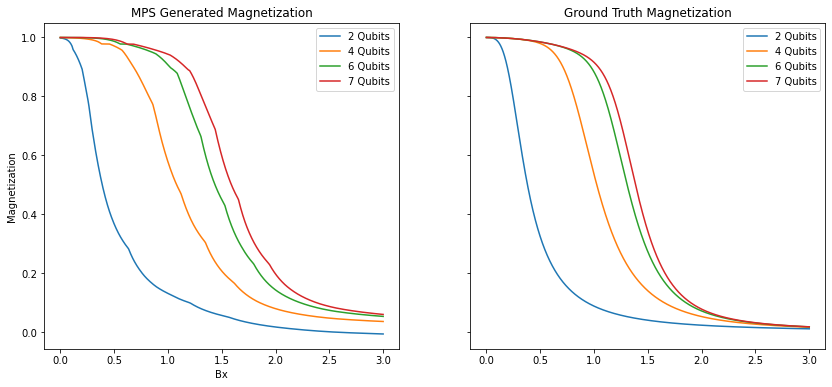

In [14]:
gen_graph(model)

In [15]:
torch.save(model.state_dict(), "2_site_model.pt")

In [16]:
def get_model(mps_size):
    PATH = "{}_site_model.pt".format(mps_size)
    device = torch.device('cpu')
    model = auto_encoder.MPS_autoencoder(mps_size)
    model.load_state_dict(torch.load(PATH, map_location=device))
    return model 

In [17]:
#model = get_model(2)

with torch.no_grad():
    encoded_spin_up = []
    encoded_spin_down = []
    
    
#     for i,(fields,wf) in enumerate(val_loader_4):
#         spin_up, spin_down = model.encode(fields)
#         print(spin_up.squeeze().shape)
#         print(spin_down.squeeze().shape)
#         encoded_spin_up.append(spin_up.squeeze())
#         encoded_spin_down.append(spin_down.squeeze())
        
#     for i,(fields,wf) in enumerate(val_loader_7):
#         spin_up, spin_down = model.encode(fields)
#         print(spin_up.squeeze().shape)
#         print(spin_down.squeeze().shape)
#         encoded_spin_up.append(spin_up.squeeze())
#         encoded_spin_down.append(spin_down.squeeze())
        
    for i,(fields,wf) in enumerate(training_loaders[0]):
        spin_up, spin_down = model.encode(fields)
        print(fields)
        print(spin_up.squeeze().shape)
        print(spin_down.squeeze().shape)
        encoded_spin_up.append(spin_up.squeeze())
        encoded_spin_down.append(spin_down.squeeze())
        
    for i,(fields,wf) in enumerate(training_loaders[1]):
        spin_up, spin_down = model.encode(fields)
        print(spin_up.squeeze().shape)
        print(spin_down.squeeze().shape)
        encoded_spin_up.append(spin_up.squeeze())
        encoded_spin_down.append(spin_down.squeeze())  

/home/jszacha1/.conda/envs/conda_env/lib/python3.9/site-packages/torch/utils/data/dataloader.py:474: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


tensor([[1.0000, 1.5777, 0.0100, 2.0000],
        [1.0000, 1.7781, 0.0100, 2.0000],
        [1.0000, 1.1611, 0.0100, 2.0000],
        [1.0000, 1.6053, 0.0100, 2.0000],
        [1.0000, 1.7451, 0.0100, 2.0000],
        [1.0000, 0.3320, 0.0100, 2.0000],
        [1.0000, 1.2680, 0.0100, 2.0000],
        [1.0000, 0.7971, 0.0100, 2.0000],
        [1.0000, 0.2182, 0.0100, 2.0000],
        [1.0000, 1.8901, 0.0100, 2.0000],
        [1.0000, 0.7742, 0.0100, 2.0000],
        [1.0000, 1.0214, 0.0100, 2.0000],
        [1.0000, 0.9699, 0.0100, 2.0000],
        [1.0000, 1.3327, 0.0100, 2.0000],
        [1.0000, 0.3603, 0.0100, 2.0000],
        [1.0000, 1.8583, 0.0100, 2.0000],
        [1.0000, 1.0467, 0.0100, 2.0000],
        [1.0000, 0.9456, 0.0100, 2.0000],
        [1.0000, 1.5842, 0.0100, 2.0000],
        [1.0000, 1.8233, 0.0100, 2.0000],
        [1.0000, 0.9227, 0.0100, 2.0000],
        [1.0000, 1.3060, 0.0100, 2.0000],
        [1.0000, 1.9341, 0.0100, 2.0000],
        [1.0000, 0.9822, 0.0100, 2

In [18]:
#model = get_model(2)

with torch.no_grad():
    encoded_spin_up = []
    encoded_spin_down = []        
       
    for i,(fields,wf) in enumerate(val_loaders[0]):
        spin_up, spin_down = model.encode(fields)
#         print(fields)
#         print(spin_up.squeeze().shape)
#         print(spin_down.squeeze().shape)
        encoded_spin_up.append(spin_up.squeeze())
        encoded_spin_down.append(spin_down.squeeze())
        
    for i,(fields,wf) in enumerate(val_loaders[1]):
        spin_up, spin_down = model.encode(fields)
#         print(spin_up.squeeze().shape)
#         print(spin_down.squeeze().shape)
        encoded_spin_up.append(spin_up.squeeze())
        encoded_spin_down.append(spin_down.squeeze())  

In [19]:
data_up = encoded_spin_up[0].numpy()
data_down = encoded_spin_down[0].numpy()
for i in range(1, len(encoded_spin_up)):
    data_up = np.vstack((data_up, encoded_spin_up[i].numpy()))
    data_down = np.vstack((data_down, encoded_spin_down[i].numpy()))
    
print(data_up.shape)
print(data_down.shape)

(11000, 5, 5)
(11000, 5, 5)


In [20]:
data_up = data_up.reshape((data_up.shape[0],25))
data_down = data_down.reshape((data_up.shape[0],25))

In [21]:
np.savetxt("mps_2_up_matrix.csv", data_up, delimiter=",")
np.savetxt("mps_2_down_matrix.csv", data_down, delimiter=",")

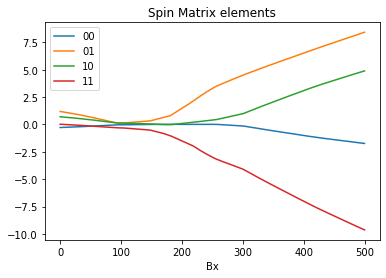

In [45]:
x = np.arange(1,10001)
x = x / (100) * 5

plt.plot(x,data_up[0:10000,0], label='00')
plt.plot(x,data_up[0:10000,1], label='01')
plt.plot(x,data_up[0:10000,2], label='10')
plt.plot(x,data_up[0:10000,3], label='11')
plt.xlabel('Bx')
plt.title('Spin Matrix elements')
plt.legend()

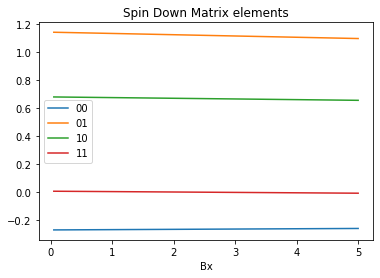

In [34]:
x = np.arange(1,101)
x = x / (100) * 5
k = 2
m = k-1
plt.plot(x,data_up[100*m:100*k,0], label='00')
plt.plot(x,data_up[100*m:100*k,1], label='01')
plt.plot(x,data_up[100*m:100*k,2], label='10')
plt.plot(x,data_up[100*m:100*k,3], label='11')
plt.xlabel('Bx')
plt.title('Spin Down Matrix elements')
plt.legend()

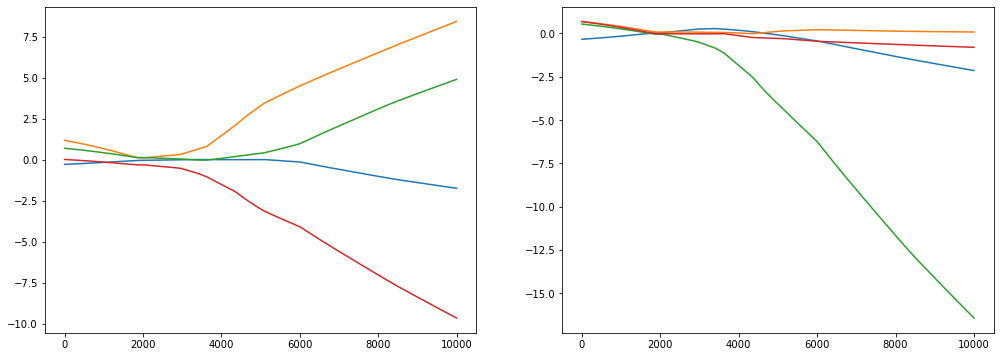

In [37]:
x = np.arange(1,10001)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,6))

for i in range(4):
    for k in range(1):
        ax1.plot(x,data_up[10000*k:10000*(k+1),i])
        ax2.plot(x,data_down[10000*k:10000*(k+1),i])


(11000, 50)
(1000,)


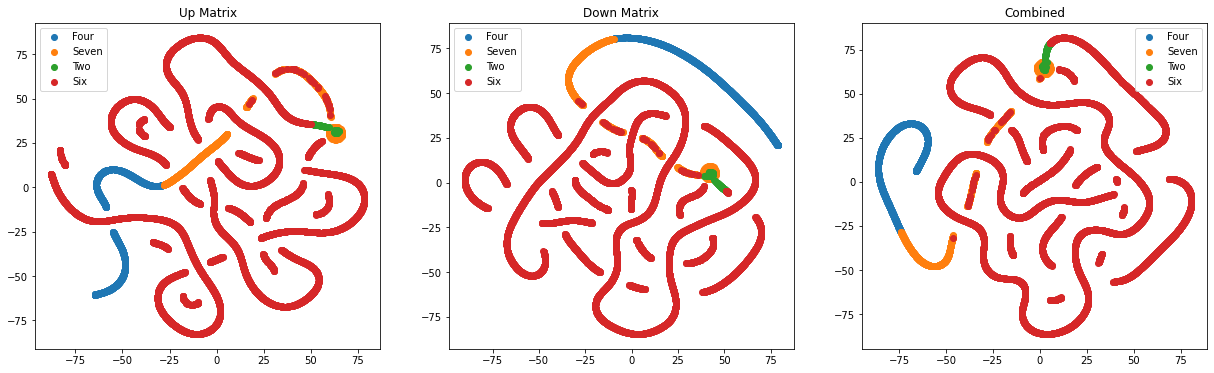

In [40]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

up=data_up
down=data_down
data = np.hstack((data_up, data_down))

print(data.shape)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21,6))

pca = TSNE(n_components=2, perplexity=50)

up = pca.fit_transform(up)
down = pca.fit_transform(down)
data = pca.fit_transform(data)

print(up[:1000][:,0].shape)
ax1.scatter(up[:1000][:,0],up[:1000][:,1] ,label='Four')
ax1.scatter(up[1000:2000][:,0],up[1000:2000][:,1] ,label='Seven')
ax1.scatter(up[2000:2100][:,0],up[2000:2100][:,1] ,label='Two')
ax1.scatter(up[2100:][:,0],up[2100:][:,1] ,label='Six')
ax1.set_title('Up Matrix')

ax1.legend()

ax2.scatter(down[:1000][:,0],down[:1000][:,1] ,label='Four')
ax2.scatter(down[1000:2000][:,0],down[1000:2000][:,1] ,label='Seven')
ax2.scatter(down[2000:2100][:,0],down[2000:2100][:,1] ,label='Two')
ax2.scatter(down[2100:][:,0],down[2100:][:,1] ,label='Six')
ax2.set_title('Down Matrix')

ax2.legend()

ax3.scatter(data[:1000][:,0],data[:1000][:,1] ,label='Four')
ax3.scatter(data[1000:2000][:,0],data[1000:2000][:,1] ,label='Seven')
ax3.scatter(data[2000:2100][:,0],data[2000:2100][:,1] ,label='Two')
ax3.scatter(data[2100:][:,0],data[2100:][:,1] ,label='Six')
ax3.set_title('Combined')
ax3.legend()




(1000,)


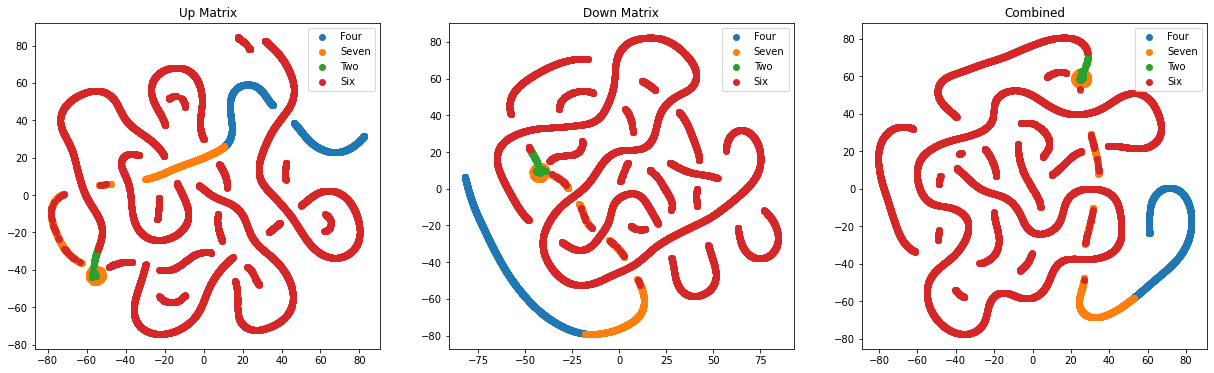

In [46]:
from sklearn.decomposition import PCA
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21,6))

pca = PCA(n_components=2)

up = pca.fit_transform(up)
down = pca.fit_transform(down)
data = pca.fit_transform(data)

print(up[:1000][:,0].shape)
ax1.scatter(up[:1000][:,0],up[:1000][:,1] ,label='Four')
ax1.scatter(up[1000:2000][:,0],up[1000:2000][:,1] ,label='Seven')
ax1.scatter(up[2000:2100][:,0],up[2000:2100][:,1] ,label='Two')
ax1.scatter(up[2100:][:,0],up[2100:][:,1] ,label='Six')
ax1.set_title('Up Matrix')

ax1.legend()

ax2.scatter(down[:1000][:,0],down[:1000][:,1] ,label='Four')
ax2.scatter(down[1000:2000][:,0],down[1000:2000][:,1] ,label='Seven')
ax2.scatter(down[2000:2100][:,0],down[2000:2100][:,1] ,label='Two')
ax2.scatter(down[2100:][:,0],down[2100:][:,1] ,label='Six')
ax2.set_title('Down Matrix')

ax2.legend()

ax3.scatter(data[:1000][:,0],data[:1000][:,1] ,label='Four')
ax3.scatter(data[1000:2000][:,0],data[1000:2000][:,1] ,label='Seven')
ax3.scatter(data[2000:2100][:,0],data[2000:2100][:,1] ,label='Two')
ax3.scatter(data[2100:][:,0],data[2100:][:,1] ,label='Six')
ax3.set_title('Combined')
ax3.legend()